# <center>eLearning User Data Analysis</center>

### <center>Project Background:</center>
This project was undertaken on a probono basis for an eLearning Platform. Sample data was provided from ~ Nov 2019 to June 2022 for users associated with its largest corporate account. 

The client wanted to understand the learning patterns of these users and also if these patterns differed by type of user (professional vs student users). The client also had a flagship course which it expected attracted the corporate users to its platform initially. They wanted to understand if users stayed and pursued other courses.


### <center>Key Observations:</center>

<b> Impact of the Primary Program </b>: Perhaps the most interesting observation is that, contrary to expectations, the first interaction that users have with the eLearning latform is not always via the Primary Program (flagship program). ~60% of students start with Ancillary Program A and ~40% of professional start one of the Ancillary Programs (predominantly Program A)

<b> Continuing Education and Ancillary Program Popularity </b>: Most users are unfortunately not continuing beyond their initial Program. The exception are the students who start with Program A and continue with the Primary Program.
    
It is clear that amongst the ancillary learning programs that the platform is hoping to grow, Program A appears to be the standout and is popular amongst both students and prodessionals alike. In order to grow participation in the other Ancillary Programs, the recommended approach would be to conduct surveys and solicit feedback from users on what they like about Program A, e.g., topic covered, presentation, instruction style. All other Ancillary Programs would need to be reviewed against this feedback.

![InitialNext.png](InitialNext.png)

![Program_Popularity.png](Program_Popularity.png)

### <center> Project Code and Analysis Details </center>
#### Data Preprocessing and Transformation 

<b> MasterData</b>: This file contains eLearning Platform usage data for each user. This is the primary data for our analysis and covers sample data from ~ Nov 2019 to June 2022. Data was cleaned and anonymized for further analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

import matplotlib.pyplot as plt
# plt.style.use("classic")
import seaborn as sns

In [2]:
df_all = pd.read_excel("MasterDataClean.xlsx")
df_all.info()
df_all.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25036 entries, 0 to 25035
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   UserID             25001 non-null  object        
 1   UserType           25036 non-null  object        
 2   Enrollment Date    25036 non-null  datetime64[ns]
 3   First Launch Date  18544 non-null  datetime64[ns]
 4   Status             25036 non-null  object        
 5   Completion Date    13428 non-null  datetime64[ns]
 6   Price              25036 non-null  int64         
 7   Time (in Hours)    25036 non-null  float64       
 8   Score              25036 non-null  int64         
 9   Media              25036 non-null  object        
 10  Program            21310 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(2), object(5)
memory usage: 2.1+ MB


,UserID,UserType,Enrollment Date,First Launch Date,Status,Completion Date,Price,Time (in Hours),Score,Media,Program
0,A001705,Professional,2021-07-05 11:39:04,NaT,Not Started,NaT,0,0.0,0,Online,NaN
1,A001325,Professional,2021-06-26 18:36:51,NaT,Not Started,NaT,0,0.0,0,Online,NaN
2,A003813,Professional,2021-06-26 16:40:04,NaT,Not Started,NaT,0,0.0,0,Online,NaN
3,A003962,Professional,2021-05-26 04:16:14,NaT,Not Started,NaT,0,0.0,0,Online,NaN
4,A001132,Professional,2021-05-04 08:35:19,NaT,Not Started,NaT,0,0.0,0,Online,NaN


General data cleaning + additional data transformation tasks per internal review and discussions with the client:

    (1) dropping those accounts where we don't have Userinfo or Program info
    (2) dropping duplicate rows (these indicate modules within each program and our analysis is to be limited to the program level
    (3) dropping those courses that were never launched
    (4) dropping waived or not started courses
    (5) adding Pre/Pandemic/Post information per First Launch Date [def period(x)] 


In [3]:
## (1 - 4)
df_all.dropna(subset = ["UserID", "Program", "First Launch Date"], how = "any", inplace = True)
df_all.drop_duplicates(subset = ["UserType","UserID","Program"], inplace = True)  #dropping duplicates
df_all = df_all[~df_all["Status"].isin(["Not Started", "Waived"])]
print(df_all.shape[0])

7169


In [4]:
df_all.UserType.value_counts()  #note student population is much smaller than the professional group
df_all.UserID.nunique()  #some users are both students and professionals

4404

### Analysis 1: How many courses does each user take?

In [5]:
_ = df_all.groupby(["UserID","UserType"], 
                 as_index = False).agg({"Program":len})  ##_ contains number of courses per student by student type
print(_.shape[0])                                                                 
_.head()

4404


,UserID,UserType,Program
0,A000001,Professional,2
1,A000003,Professional,1
2,A000004,Professional,1
3,A000005,Professional,1
4,A000006,Professional,1


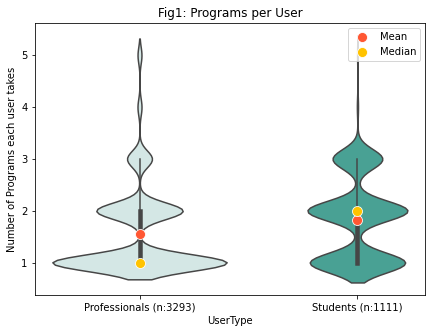

In [6]:
plt.figure(figsize = (7,5));
colors = ["#d1eae7","#3ab09e"]
sns.violinplot(data = _, x= "UserType", y = "Program", 
               palette = colors, alpha = 0.3).set_title("Fig1: Programs per User");

p_count = _[_["UserType"] == "Professional"].shape[0]
s_count = _[_["UserType"] == "Student"].shape[0]
p_mean = float(_[_["UserType"] == "Professional"].mean().round(2))
p_median = float(_[_["UserType"] == "Professional"].median().round(2))
s_mean = float(_[_["UserType"] == "Student"].mean().round(2))
s_median = float(_[_["UserType"] == "Student"].median().round(2))

sns.scatterplot([0,1],[p_mean, s_mean], zorder = 3, s=100, color = "#FF5733", marker="o", label = "Mean");
sns.scatterplot([0,1],[p_median, s_median], zorder = 3, s=100, color="#FFC300", marker="o", label = "Median");
plt.ylabel("Number of Programs each user takes");
plt.gca().set_xticklabels([("Professionals (n:"+str(p_count)+")"),("Students (n:"+str(s_count)+")")]);
plt.savefig("ProgramsPerUser.png")

<b>Observation:</b> Each student typically takes two programs while each professional typically participates in 1.

### Analysis 2: Which courses are most popular?

In [7]:
_ = (df_all.groupby(["UserType","Program"]).size() / df_all.groupby(["UserType"]).size() * 100).round().reset_index()
_.rename(columns = {0:"Percent"}, inplace = True)
_.sort_values(["UserType", "Program", "Percent"], ascending = False, inplace = True)
_

,UserType,Program,Percent
9,Student,Primary Program,51.0
8,Student,Ancillary Program D,12.0
7,Student,Ancillary Program C,0.0
6,Student,Ancillary Program B,0.0
5,Student,Ancillary Program A,36.0
4,Professional,Primary Program,57.0
3,Professional,Ancillary Program D,8.0
2,Professional,Ancillary Program C,4.0
1,Professional,Ancillary Program B,4.0
0,Professional,Ancillary Program A,27.0


In [8]:
categories= ["Primary Program","Ancillary Program A","Ancillary Program B","Ancillary Program C","Ancillary Program D"]

_["Program"] = pd.Categorical(_["Program"], categories = categories)
_.sort_values(["UserType","Program"], inplace = True)

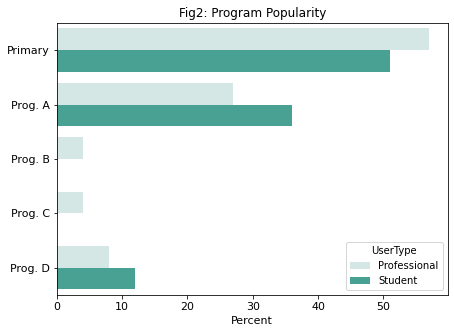

In [9]:
plt.figure(figsize = (7,5))
colors = ["#d1eae7", "#3ab09e"]
sns.barplot(data =_, x = "Percent", y = "Program", hue = "UserType", 
            palette = colors).set_title("Fig2: Program Popularity", fontsize = 12);
plt.gca().set_yticklabels(["Primary","Prog. A","Prog. B","Prog. C","Prog. D"]);
plt.xticks(fontsize = 11);
plt.xlabel("Percent", fontsize = 11);
plt.yticks(fontsize = 11);
plt.ylabel("", fontsize = 11);
plt.savefig("Program_Popularity.png")

<b>Observation:</b> As expected, the primary learning program is the most popular amongst students and professionals alike. Amongst the ancillary learning programs that the platform is hoping to grow, program A appears to be the standout and is popular amongst both students and prodessionals alike. Ancillary program D also has limited popularity, especially amongst the student group.

### Analysis 3: Which program do users start with? How do they continue?

In [10]:
usertype = ["Professional","Student"]
test = {}
for user in usertype:
    sub_df = df_all[df_all["UserType"]==user]
   
    ##find first course:
    starts = {}      #absolute number of users starting with each course
    startsp = {}     #of users starting with each course

    
    ##we group by each studentID and we increase the counter(starts) based on the course this student started with
    for group, frame in sub_df.groupby("UserID"):
        frame.sort_values("First Launch Date", inplace = True)

        if frame.iloc[0,10] == "Primary Program":
            starts["Primary Program"] = starts.get("Primary Program",0) + 1 
        elif frame.iloc[0,10] == "Ancillary Program A":
            starts["Program A"] = starts.get("Program A",0) + 1 
        elif frame.iloc[0,10] == "Ancillary Program B":
            starts["Program B"] = starts.get("Program B",0) + 1 
        elif frame.iloc[0,10] == "Ancillary Program C":
            starts["Program C"] = starts.get("Program C",0) + 1 
#         elif frame.iloc[0,10] == "Ancillary Program D":
        else: #Program D
            starts["Program D"] = starts.get("Program D",0) + 1 
    total = 0
    for v in starts.values(): 
        total += v
    for k,v in starts.items():
        startsp[k] = round(v/total *100,2)
    
    test[user] = startsp
    test_pd = pd.DataFrame(test)

test_pd.fillna(0, inplace = True)
categories= ["Primary Program","Program A","Program B","Program C","Program D"]
test_pd = test_pd.reindex(categories)    

print("Which program do users take first on the eLearning Platform?")
test_pd

Which program do users take first on the eLearning Platform?


,Professional,Student
Primary Program,60.86,39.24
Program A,33.07,60.04
Program B,1.70,0.00
Program C,1.91,0.00
Program D,2.46,0.72


<b> Observation: </b> Perhaps the most interesting observation is that contrary to expectations, the first iteration that users have is not always through the primary program. ~60% of students start with Ancillary Program A and ~40% of professional start one of the Ancillary Programs (predominantly Program A with 33%)

### Analysis 4: How do they continue? 

For professionals, since a majority of the users start with the Primay Program, for simplicity, we're just checking what course, if any, users take after this (part A). We ignore the population that starts with other courses

For students, we check which course they move onto after starting (B1) Ancillary A or (B2) the Primary Program

In [11]:
def next_course(sub_df):
    
    ## we run the below loop twice, 
    ##once for those who start with the Primary program and next for those who start with Program A
    first_programs = ["Primary Program", "Ancillary Program A"]
    results = pd.DataFrame(index = ["Primary Program", "Program A", "Program B", 
                                     "Program C", "Program D", "None"])

    for prog in first_programs:
        prof_next = {}
        for group, frame in sub_df.groupby("UserID"):
            frame.sort_values("First Launch Date", inplace = True)

            if frame.iloc[0,10] == prog:
                temp = frame[frame["Program"] != prog]  #exclude the first program they took and and look at everything else

                if len(temp) == 0:  #User does not take any other courses
                    prof_next["None"] = prof_next.get("None",0) + 1
                elif temp.iloc[0,10] == "Primary Program":
                    prof_next["Primary Program"] = prof_next.get("Primary Program",0) + 1 
                elif temp.iloc[0,10] == "Ancillary Program A":
                    prof_next["Program A"] = prof_next.get("Program A",0) + 1 
                elif temp.iloc[0,10] == "Ancillary Program B":
                    prof_next["Program B"] = prof_next.get("Program B",0) + 1 
                elif temp.iloc[0,10] == "Ancillary Program C":
                    prof_next["Program C"] = prof_next.get("Program C",0) + 1 
                else: #Program D
                    prof_next["Program D"] = prof_next.get("Program D",0) + 1 

        prof_nextp = {}
        total = 0
        for v in prof_next.values(): 
            total += v
        for k,v in prof_next.items():
            prof_nextp[k] = round(v/total *100,2)
    #     print(pd.Series(prof_nextp))
        results[prog] = pd.Series(prof_nextp)

    results.rename(columns = {"Primary Program": "Those starting with Primary",
                              "Ancillary Program A": "Those starting with Program A"}, inplace = True)
    results = results.transpose()
    return results

In [12]:
## We call the next_course function twice, first for professionals and next for students. 
prof_df = df_all[df_all["UserType"] == "Professional"]
prof_next_course = next_course(prof_df)

print("Do professionals continue after their initial program?")
prof_next_course

Do professionals continue after their initial program?


,Primary Program,Program A,Program B,Program C,Program D,None
Those starting with Primary,NaN,10.68,0.75,0.60,3.14,84.83
Those starting with Program A,72.64,NaN,3.58,2.57,7.53,13.68


In [13]:
stud_df = df_all[df_all["UserType"] == "Student"]
stud_next_course = next_course(stud_df)

print("Do students continue after their initial program?")
stud_next_course

Do students continue after their initial program?


,Primary Program,Program A,Program B,Program C,Program D,None
Those starting with Primary,NaN,14.22,NaN,NaN,4.13,81.65
Those starting with Program A,86.81,NaN,NaN,NaN,2.55,10.64


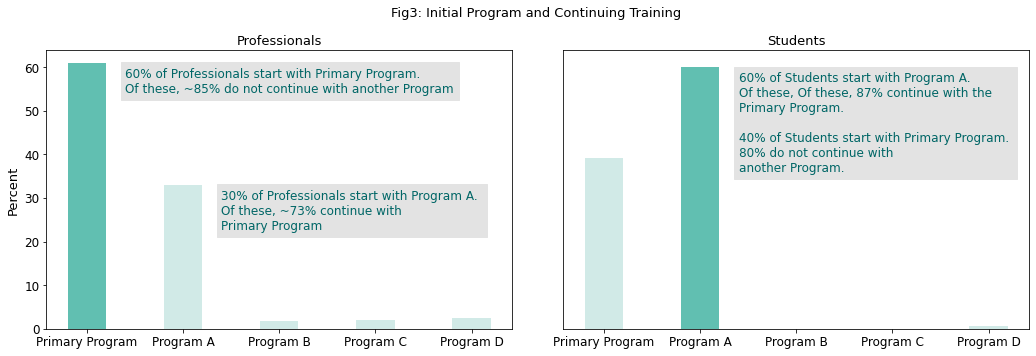

In [14]:
plt.figure(figsize = (15,5));

# test_pd.sort_values("Professional", ascending = False, inplace = True)
plt.subplot(1,2,1);
clrs1 = ['#d1eae7' if (x < np.max(test_pd["Professional"])) else '#61bfb1' for x in test_pd["Professional"]];
plt.bar(x =  test_pd.index, height = test_pd.Professional, width =0.4, color = clrs1);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.ylabel("Percent", fontsize = 13);
plt.title("Professionals", fontsize = 13);

##Text is based on prof_next_course
plt.text(x =  0.4, y = 60, s = """60% of Professionals start with Primary Program. 
Of these, ~85% do not continue with another Program""", 
va = "top", backgroundcolor = "#E3E3E3", color = "#006666", fontsize = 12);

plt.text(x =  1.4, y = 32, s = """30% of Professionals start with Program A. 
Of these, ~73% continue with 
Primary Program""", 
va = "top", backgroundcolor = "#E3E3E3", color = "#006666", fontsize = 12);


# test_pd.sort_values("Student", ascending = False, inplace = True)
plt.subplot(1,2,2, sharey = plt.subplot(1,2,1));
plt.gca().yaxis.set_visible(False)
clrs2 = ['#d1eae7' if x < float(40) else '#61bfb1' for x in test_pd["Student"]];
plt.bar(x = test_pd.index, height = test_pd.Student, width =0.4, color = clrs2);
plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.title("Students", fontsize = 13);

##Text is based on stuf_next_course
plt.text( x=  1.4, y = 59, s = """60% of Students start with Program A. 
Of these, Of these, 87% continue with the 
Primary Program.

40% of Students start with Primary Program. 
80% do not continue with 
another Program.""", 
va = "top", backgroundcolor = "#E3E3E3", color = "#006666", fontsize = 12);

plt.suptitle("Fig3: Initial Program and Continuing Training", fontsize = 13);
plt.tight_layout();
plt.savefig("InitialNext.png")

#### Observations: 
* 60% of Professionals start with Primary Program. Of these, ~85% do not continue with another Program.
* 30% of Professionals start with Program A. Of these, ~73% continue with the Primary Program.
* 60% of Students start with Program A. Of these, Of these, 87% continue with the Primary Program.
* 40% of Students start with Primary Program. 80% do not continue with another Program.